# A Basic Model

In this example application it is shown how a simple time series model can be developed to simulate groundwater levels. The recharge (calculated as precipitation minus evaporation) is used as the explanatory time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pastas as ps
ps.show_versions()

Python version: 3.9.13
NumPy version: 1.21.5
Pandas version: 1.4.4
SciPy version: 1.9.1
Matplotlib version: 3.5.2
Numba version: 0.55.1
LMfit version: 1.1.0
Latexify version: Not Installed
Pastas version: 1.0.1


### 1. Importing the dependent time series data
In this codeblock a time series of groundwater levels is imported using the `read_csv` function of `pandas`. As `pastas` expects a `pandas` `Series` object, the data is squeezed. To check if you have the correct data type (a `pandas Series` object), you can use `type(oseries)` as shown below. 

The following characteristics are important when importing and preparing the observed time series:
- The observed time series are stored as a `pandas Series` object.
- The time step can be irregular.

The data type of the oseries is: <class 'pandas.core.series.Series'>


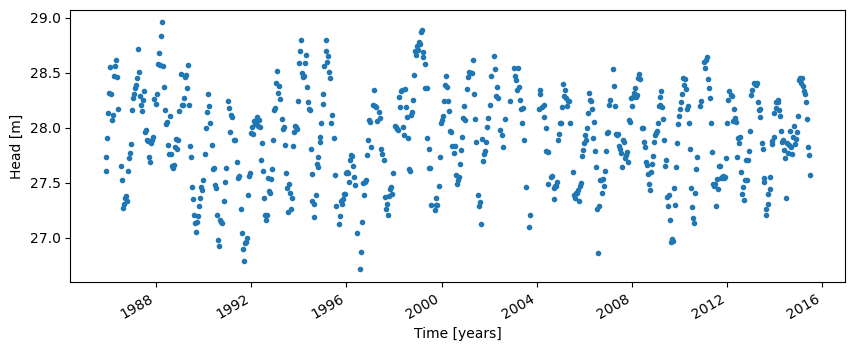

In [2]:
# Import groundwater time seriesm and squeeze to Series object
gwdata = pd.read_csv(
    "data/head_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()
print("The data type of the oseries is: %s" % type(gwdata))

# Plot the observed groundwater levels
gwdata.plot(style=".", figsize=(10, 4))
plt.ylabel("Head [m]")
plt.xlabel("Time [years]");

### 2. Import the independent time series
Two explanatory series are used: the precipitation and the potential evaporation. These need to be `pandas Series` objects, as for the observed heads.

Important characteristics of these time series are:
- All series are stored as `pandas Series` objects.
- The series may have irregular time intervals, but then it will be converted to regular time intervals when creating the time series model later on.
- It is preferred to use the same length units as for the observed heads.

The data type of the precip series is: <class 'pandas.core.series.Series'>
The data type of the evap series is: <class 'pandas.core.series.Series'>
The data type of the recharge series is: <class 'pandas.core.series.Series'>


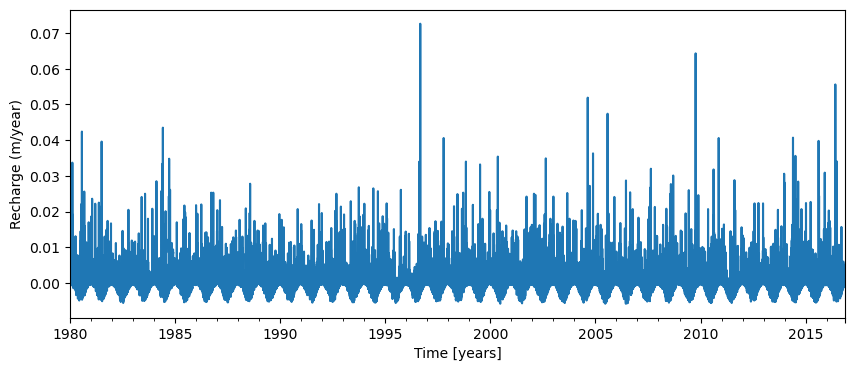

In [3]:
# Import observed precipitation series
precip = pd.read_csv(
    "data/rain_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()
print("The data type of the precip series is: %s" % type(precip))

# Import observed evaporation series
evap = pd.read_csv(
    "data/evap_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()
print("The data type of the evap series is: %s" % type(evap))

# Calculate the recharge to the groundwater
recharge = precip - evap
print("The data type of the recharge series is: %s" % type(recharge))

# Plot the time series of the precipitation and evaporation
plt.figure()
recharge.plot(label="Recharge", figsize=(10, 4))
plt.xlabel("Time [years]")
plt.ylabel("Recharge (m/year)");

### 3. Create the time series model
In this code block the actual time series model is created. First, an instance of the `Model` class is created (named `ml` here). Second, the different components of the time series model are created and added to the model. The imported time series are automatically checked for missing values and other inconsistencies. The keyword argument fillnan can be used to determine how missing values are handled. If any nan-values are found this will be reported by `pastas`.

In [4]:
# Create a model object by passing it the observed series
ml = ps.Model(gwdata, name="GWL")

# Add the recharge data as explanatory variable
sm = ps.StressModel(recharge, ps.Gamma(), name="recharge", settings="evap")
ml.add_stressmodel(sm)

INFO: Time Series None: 22 nan-value(s) was/were found and filled with: interpolate.
INFO: timeseries._fill_nan(): Time Series None: 22 nan-value(s) was/were found and filled with: interpolate.


### 4. Solve the model
The next step is to compute the optimal model parameters. The default solver  uses a non-linear least squares method for the optimization. The python package `scipy` is used (info on `scipy's` least_squares solver can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)). Some standard optimization statistics are reported along with the optimized parameter values and correlations.

In [5]:
ml.solve()

INFO: Time Series None: 22 nan-value(s) was/were found and filled with: interpolate.
INFO: timeseries._fill_nan(): Time Series None: 22 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series None was extended in the past to 1975-11-17 00:00:00 with the mean value (0.00048) of the time series.
INFO: timeseries._fill_before(): Time Series None was extended in the past to 1975-11-17 00:00:00 with the mean value (0.00048) of the time series.


Fit report GWL                      Fit Statistics
nfev    20                     EVP           91.28
nobs    644                    R2             0.91
noise   True                   RMSE           0.13
tmin    1985-11-14 00:00:00    AIC        -3234.20
tmax    2015-06-28 00:00:00    BIC        -3211.87
freq    D                      Obj            2.09
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   753.594605   ±5.17%  215.830338  True
recharge_n     1.054413   ±1.50%    1.000000  True
recharge_a   135.886803   ±7.05%   10.000000  True
constant_d    27.552231   ±0.08%   27.900078  True
noise_alpha   61.768654  ±12.66%   15.000000  True


### 5. Plot the results
The solution can be plotted after a solution has been obtained.

<AxesSubplot:title={'center':'Results of GWL'}, xlabel='date', ylabel='Groundwater levels [meter]'>

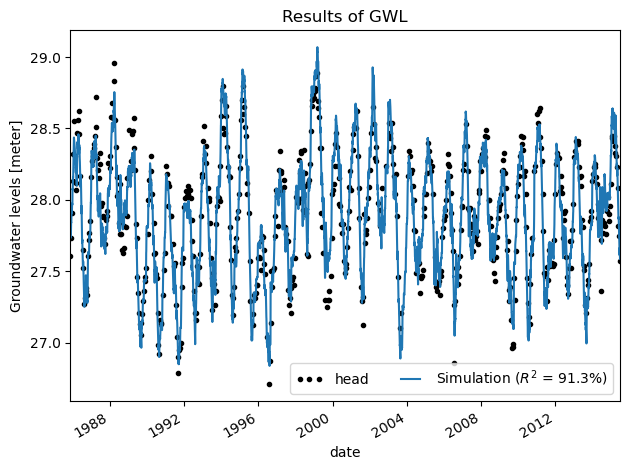

In [6]:
ml.plot()

# TEST 

*Challenges*
- when you call ml.parameters in solver.py it returns the default (uncalibrated) parameters with NaN for "Optimal" and "stderr". 
- is it possible not to reset the parameters and call the calibrated from "leastsquares"? 

In [7]:
ml2 = ml.copy()

INFO: Time Series None: 22 nan-value(s) was/were found and filled with: interpolate.
INFO: timeseries._fill_nan(): Time Series None: 22 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series None was extended in the past to 1975-11-17 00:00:00 with the mean value (0.00048) of the time series.
INFO: timeseries._fill_before(): Time Series None was extended in the past to 1975-11-17 00:00:00 with the mean value (0.00048) of the time series.


In [8]:
ml2.solve(solver=ps.DREAMSolve(ml.parameters))

Initializing the  DiffeRential Evolution Adaptive Metropolis (DREAM) algorithm  with  50000  repetitions
The objective function will be maximized
Starting the DREAM algotrithm with 50000 repetitions...
Initialize  7  chain(s)...
1 of 50000, maximal objective function=-0.128463, time remaining: 22:16:57
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'dream.csv' created.
Beginn of Random Walk
Acceptance rates [%] =100. 100. 100. 100. 100. 100. 100.
Convergence rates =2.0073 1.7767 1.7302 1.4904 1.5626


C:\Users\Matevz\anaconda3\lib\site-packages\spotpy\algorithms\dream.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = 2.38 / np.sqrt(2 * nchain_pairs * d_star)  # /self.gammalevel


#############
Convergence has been achieved after 266 of 50000 runs! Finally, 1000 runs will be additionally sampled to form the posterior distribution
#############
Initializing the  DiffeRential Evolution Adaptive Metropolis (DREAM) algorithm  with  1266  repetitions
The objective function will be maximized
Acceptance rates [%] = 98.11 100.   100.   100.   100.   100.   100.  
Convergence rates =1.0724 1.1278 1.0973 1.0562 1.0573
333 of 1266, maximal objective function=-0.125607, time remaining: 00:00:06
Acceptance rates [%] = 99.01 100.    99.01 100.   100.   100.   100.  
Convergence rates =1.0601 1.0359 1.1516 1.0143 1.0251
679 of 1266, maximal objective function=-0.125607, time remaining: 00:00:03
Acceptance rates [%] = 98.68 100.    99.34 100.   100.   100.    99.34
Convergence rates =1.0381 1.0475 1.0436 1.0662 1.0532

*** Final SPOTPY summary ***
Total Duration: 5.88 seconds
Total Repetitions: 1001
Maximal objective value: -0.12517
Corresponding parameter setting:
recharge_A: 

TypeError: unsupported format string passed to NoneType.__format__

# Using SpotPy with Pastas

- use prior from leastsquares

In [ ]:
from spotpy.parameter import Uniform, Normal
import spotpy
from spotpy.likelihoods import logLikelihood
from spotpy.objectivefunctions import rmse
from spotpy.likelihoods import gaussianLikelihoodMeasErrorOut as GausianLike
from spotpy.analyser import plot_parameter_trace
from spotpy.analyser import plot_posterior_parameter_histogram

In [ ]:
class spot_setup(object):  
    def __init__(self, ml, obj_func=None, params=None):
        # Just a way to keep this example flexible and applicable to various examples
        self.ml = ml
        self.obj_func = obj_func
        self.params = params
    def parameters(self):
        if self.params is None:
            pars = []
            for par in self.ml.parameters.index:
                pars.append(Normal(par, mean=self.ml.parameters.loc[par, "optimal"], 
                                   stddev=self.ml.parameters.loc[par, "stderr"]))
        else:
            pars = self.params
        return spotpy.parameter.generate(pars)
    
    def simulation(self, x):
        # Here the model is actualy started with a unique parameter combination that it gets from spotpy for each time the model is called
        prs = [x[0], x[1], x[2], x[3], x[4]]
        return self.ml.simulate(prs)
    
    def evaluation(self):
        return self.ml.observations()

    def objectivefunction(self, simulation, evaluation):
        if self.obj_func is not None:
            like = self.obj_func(evaluation, simulation.loc[evaluation.index])
        else:
            like = -rmse(evaluation, simulation.loc[evaluation.index])
            
        return like 

from spotpy.likelihoods import gaussianLikelihoodMeasErrorOut, logLikelihood

In [ ]:
#Select number of maximum repetitions
rep=50000

# Select five chains and set the Gelman-Rubin convergence limit
nChains                = 7
convergence_limit      = 1.2

# Other possible settings to modify the DREAM algorithm, for details see Vrugt (2016)
nCr                    = 3
eps                    = 10e-6
runs_after_convergence = 1000
acceptance_test_option = 6

1. Set spot_setup() 
2. Define algorithm/sampler
3. Solve

Combine 1 and 2

## We are going to build two samplers

* The default (RMSE) Objective function.
* loglikelihood.
* Uniform prior

In [ ]:
ml3 = ml.copy()
sampler = spotpy.algorithms.dream(spot_setup(ml3), dbname="dream1", dbformat="csv", save_sim=False)

In [ ]:
# USE RMSE as objective function and default params
r_hat = sampler.sample(rep, runs_after_convergence=runs_after_convergence)

In [ ]:
# Import results
results = spotpy.analyser.load_csv_results('dream1')[-1000:]
opt = list(results[results["like1"].argmax()])[1:-1]

In [ ]:
results["parrecharge_A"].std()

In [ ]:
# Plot the optimal fit
ml.simulate(opt).plot(figsize=(22,3), color="red")
ml.get_output_series()["Head_Calibration"].dropna().plot()

In [ ]:
# Create time series with the last 1000 samples from the posterior chain
sims = []
for rs in results:
    sims.append(ml.simulate([rs[1], rs[2], rs[3], rs[4], rs[5]]))

In [ ]:
# Plot the 95% uncertainty bands
sim_opt = ml.simulate(opt)
plt.fill_between(sim_opt.index, np.quantile(sims, 0.05, axis=0), np.quantile(sims, 0.95, axis=0))
plt.plot(sim_opt, color="k", lw=0.5)

In [ ]:
# Use the Loglikelihood and params from Least squares
ml4 = ml.copy()
sampler = spotpy.algorithms.dream(spot_setup(ml4, obj_func=logLikelihood), 
                                  dbname="dream2", dbformat="csv", save_sim=False)

In [ ]:
# 
r_hat = sampler.sample(rep, runs_after_convergence=runs_after_convergence)

In [ ]:
# Import results
results = spotpy.analyser.load_csv_results('dream2')#[-1000:]
opt = list(results[results["like1"].argmax()])[1:-1]

In [ ]:
# Plot the optimal fit
ml.simulate(opt).plot(figsize=(22,3), color="red")
ml.get_output_series()["Head_Calibration"].dropna().plot()

In [ ]:
# Create time series with the last 1000 samples from the posterior chain
sims = []
for rs in results[-1000:]:
    sims.append(ml.simulate([rs[1], rs[2], rs[3], rs[4], rs[5]]))

In [ ]:
# Plot the 95% uncertainty bands
sim_opt = ml.simulate(opt)
plt.fill_between(sim_opt.index, np.quantile(sims, 0.05, axis=0), np.quantile(sims, 0.95, axis=0))
plt.plot(sim_opt, color="k", lw=0.5)

In [ ]:
ml.parameters#.loc["constant_d","pmin"] = 20

In [ ]:
# Uniform prior
ml5 = ml.copy()
ml5.parameters.loc["constant_d","pmin"] = 20
ml5.parameters.loc["constant_d","pmax"] = 40
ml5.parameters.loc["recharge_a","pmax"] = 50
ml5.parameters.loc["noise_alpha","pmax"] = 100
pars = []
for par in ml5.parameters.index:
    pars.append(Uniform(par, low=ml5.parameters.loc[par, "pmin"], 
                                   high=ml5.parameters.loc[par, "pmax"]))

In [ ]:
# Use the Loglikelihood and params from Least squares
sampler = spotpy.algorithms.dream(spot_setup(ml5, obj_func=logLikelihood, params=pars), 
                                  dbname="dream3", dbformat="csv", save_sim=False)

In [ ]:
# 
r_hat = sampler.sample(rep, runs_after_convergence=5000)

In [ ]:
# Import results
results = spotpy.analyser.load_csv_results('dream3')#[-1000:]
opt = list(results[results["like1"].argmax()])[1:-1]

In [ ]:
# Plot the optimal fit
ml.simulate(opt).plot(figsize=(22,3), color="red")
ml.get_output_series()["Head_Calibration"].dropna().plot()

In [ ]:
parameters = spotpy.parameter.get_parameters_array(spot_setup(ml5))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,8))
for par_id in range(len(parameters)):
    plot_parameter_trace(ax[par_id][0], results, parameters[par_id])
    plot_posterior_parameter_histogram(ax[par_id][1], results, parameters[par_id])

ax[-1][0].set_xlabel('Iterations')
ax[-1][1].set_xlabel('Parameter range')
plt.show()

In [ ]:
spotpy.analyser.plot_gelman_rubin(results, r_hat)

### Origin of the series
* The rainfall data is taken from rainfall station Heibloem in The Netherlands.
* The evaporation data is taken from weather station Maastricht in The Netherlands.
* The head data is well B58C0698, which was obtained from Dino loket